# University of Kentucky (UK) WSI Inference - 17

In [31]:
# Imports
from pathlib import Path
import large_image, torch, sys
from pprint import pprint
from tqdm.notebook import tqdm
import cv2 as cv
from transformers import (
    SegformerForSemanticSegmentation, SegformerImageProcessor
)
from PIL import Image
import geopandas  as gpd
from dsa_helpers.girder_utils import login
import matplotlib.pyplot as plt

from shapely.geometry import Polygon
from shapely.affinity import scale

sys.path.append("..")
from config import COLORS
from utils import unzip_file, mask_to_geojson

In [32]:
# Authenticate girder client.
dsa_api_url = "http://bdsa.pathology.emory.edu:8080/api/v1/"
gc = login(dsa_api_url)

In [33]:
# Parameters
model_dir = "/home/bhavesh/ml-work/20imgs/models"
local_wsi_dir = "/wsi_archive/APOLLO_NP/"
wsi_name = "E15-125_3_AB.svs"
item_id = "67ffc210a0350dce447ede71"
# Convert to Path
model_dir = Path(model_dir)
folder = gc.getFolder("67ddb0782fc8ce397c5ef7fb")  # Ensure this folder ID is correct.
items = list(gc.listItem(folder["_id"]))
from glob import glob
fps = list(glob("/wsi_archive/APOLLO_NP/**/*.svs", recursive=True))
from pathlib import Path
fp_dict = {}
for fp in fps:
    fp = Path(fp)    
    fp_dict[fp.name] = str(fp)
    
local_wsi_path  = fp_dict[wsi_name]
local_wsi_dir = Path(local_wsi_dir)

local_wsi_path


'/wsi_archive/APOLLO_NP/2015/E15-125/ScannedSlides/unknown/unknown/E15-125_3_AB.svs'

In [35]:
# Look for available models to load from DSA.
model_items = {}

# Step 1: Find the collection "Emory ADRC Cohorts"
for collection in gc.listCollection():
    if collection['name'] == 'Emory ADRC Cohorts':
        # Step 2: Find the folder "Bhavesh" in this collection
        for bhavesh_folder in gc.listFolder(collection['_id'], parentFolderType="collection"):
            if bhavesh_folder['name'] == 'Bhavesh':
                # Step 3: Find the subfolder "model" inside "Bhavesh"
                for model_folder in gc.listFolder(bhavesh_folder['_id'], parentFolderType="folder"):
                    if model_folder['name'] == 'model':
                        # Step 4: Get items inside "model"
                        model_items = {
                            item['name']: item
                            for item in gc.listItem(model_folder['_id'])
                        }
# Print model names
for model_name in model_items.keys():
    print(model_name)

segformer-uk-model-17-mag10
segformer-uk-model-27-mag10
segformer-uk-model-7-mag10


In [36]:
# Use a model to test.
model_name = "segformer-uk-model-17-mag10"
model_item = model_items[model_name]

# Check if the model exists.
if not (model_dir / model_name).is_dir():
    # Download it from the DSA.        
    # Get the model file of name "checkpoint.zip".
    for file in gc.listFile(model_item['_id']):
        if file['name'] == "checkpoint.zip":
            zip_path = model_dir / f"{model_name}.zip"
            _ = gc.downloadFile(file['_id'], str(zip_path))
            unzip_file(zip_path, model_dir / model_name)
            
            # Remove the zip file.
            zip_path.unlink()
            break
        

In [28]:
# Load the model.
model = SegformerForSemanticSegmentation.from_pretrained(
    model_dir / model_name, 
    local_files_only=True, 
    device_map='cuda'
)
processor = SegformerImageProcessor()

In [38]:
# Model metadata includes important information for correct inference.
model_metadata = model_item['meta']
pprint(model_metadata)

{'annotation_doc_name': 'Gray White Segmentation',
 'deconvolve': False,
 'dsa_api_url': 'http://bdsa.pathology.emory.edu:8080/api/v1',
 'dsa_folder_id': '673b566f900c0c0559bf156f',
 'label2idx': {'Background': 0,
               'Exclude': 5,
               'Gray Matter': 1,
               'Leptomeninges': 4,
               'Superficial': 3,
               'White Matter': 2},
 'mag': 10,
 'tile_size': 512}


In [39]:

# Get the tile source of the large image.
ts = large_image.getTileSource(
    local_wsi_path
)

# Get the large image metadata.
large_image_metadata = ts.getMetadata()

# Multiplitive factor to go from scan mag to desired mag.
mag = model_metadata['mag']
sf = mag / large_image_metadata['magnification']

tile_size = model_metadata['tile_size']
fr_tile_size = int(tile_size / sf)

# Get a list of (x, y) values for the top left corner of each tile to be processed.
xys = [
    (x, y)
    for x in range(0, large_image_metadata['sizeX'], fr_tile_size) 
    for y in range(0, large_image_metadata['sizeY'], fr_tile_size)
]

print(f"{len(xys)} tiles to process.")

# Predicting in batches.
batch_size = 8
idx = list(range(0, len(xys), batch_size))

print(f'Batches = {len(idx)}, with batch size = {batch_size}.')

wsi_polygons = []

for i in tqdm(idx):
    imgs = []
    
    batch_xys = xys[i:i+batch_size]
    
    for xy in batch_xys:
        x, y = xy
        
        img = ts.getRegion(
            region={
                'left': x, 'top': y, 
                'right':x + fr_tile_size, 'bottom': y + fr_tile_size
            },
            format=large_image.constants.TILE_FORMAT_NUMPY,
            scale={'magnification': mag},
        )[0][:, :, :3]
                                                    
        # Pad the image if needed
        if img.shape[:2] != (tile_size, tile_size):
            img = cv.copyMakeBorder(
                img, 0, tile_size - img.shape[0], 0, 
                tile_size - img.shape[1], cv.BORDER_CONSTANT, None, (255, 255, 255)
            )
            
        imgs.append(Image.fromarray(img))
        
    # Preprocess the images.
    inputs = processor(imgs, return_tensors="pt")
    inputs = inputs.to(model.device)  
    
    # Predict
    with torch.no_grad():
        output = model(inputs["pixel_values"])
        
        # Get the logits out.
        logits = torch.nn.functional.interpolate(
            output.logits,
            size=tile_size,
            mode='bilinear',
        )
        
        # Get predicted class labels
        masks = torch.argmax(logits, dim=1).cpu().numpy()
        
    # Loop through each mask to extract the contours as shapely polygons.
    for i, mask in enumerate(masks):
        x, y = batch_xys[i]
        polygon_and_labels = mask_to_geojson(
            mask, x_offset=int(x * sf), y_offset=int(y * sf),
        )
        
        for polygon_and_label in polygon_and_labels:
            polygon, label = polygon_and_label
            label = int(label)
            
            # Do something with the polygon and label.
            wsi_polygons.append             ([polygon, label])

2166 tiles to process.
Batches = 271, with batch size = 8.


  0%|          | 0/271 [00:00<?, ?it/s]

<Axes: >

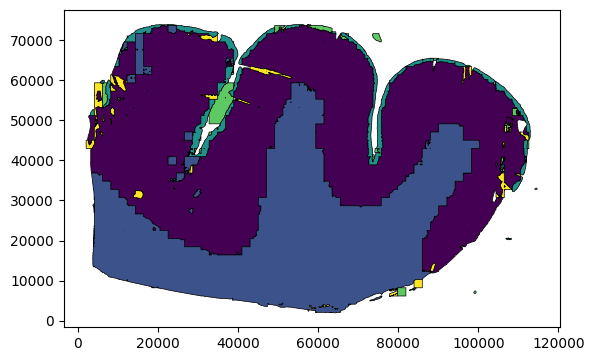

In [40]:
# Convert polygons and labels into a GeoDataFrame.
gdf = gpd.GeoDataFrame(wsi_polygons, columns=["geometry", "label"])
# Read the dataframe from parquet file.
# gdf = gpd.read_parquet("20x-inference-polygons.parquet")
# Apply a buffer to make edges touch.
gdf["geometry"] = gdf["geometry"].buffer(1)

# Dissolve the dataframe by the label.
gdf = gdf.dissolve(by="label", as_index=False)

# Remove the buffer, removing takes a lot of time.
# gdf["geometry"] = gdf["geometry"].buffer(-1)

# Scale so the coordinates are in scan resolution.
sf = mag / large_image_metadata['magnification']
gdf["geometry"] = gdf["geometry"].apply(
    lambda geom: scale(geom, xfact=1/sf, yfact=1/sf, origin=(0, 0))
)

gdf.plot(column="label", edgecolor="black", linewidth=0.5)

In [41]:
# Print the label to id saved from metadata.
pprint(model_metadata['label2idx'])

# Set the config based on the metadata.
config = {}

for k, v in model_metadata['label2idx'].items():
    config[v] = COLORS[v]
    config[v]["label"] = k
    
config

{'Background': 0,
 'Exclude': 5,
 'Gray Matter': 1,
 'Leptomeninges': 4,
 'Superficial': 3,
 'White Matter': 2}


{0: {'fillColor': 'rgba(255, 255, 255, 0.5)',
  'lineColor': 'rgb(255, 255, 255)',
  'label': 'Background'},
 5: {'fillColor': 'rgba(255, 0, 0, 0.5)',
  'lineColor': 'rgb(255, 0, 0)',
  'label': 'Exclude'},
 1: {'fillColor': 'rgba(0, 128, 0, 0.5)',
  'lineColor': 'rgb(0, 128, 0)',
  'label': 'Gray Matter'},
 4: {'fillColor': 'rgba(0, 0, 0, 0.5)',
  'lineColor': 'rgb(0, 0, 0)',
  'label': 'Leptomeninges'},
 3: {'fillColor': 'rgba(255, 255, 0, 0.5)',
  'lineColor': 'rgb(255, 255, 0)',
  'label': 'Superficial'},
 2: {'fillColor': 'rgba(0, 0, 255, 0.5)',
  'lineColor': 'rgb(0, 0, 255)',
  'label': 'White Matter'}}

In [42]:
# Explode the dataframe to get individual polygons.
gdf_exploded = gdf.copy().explode(index_parts=False)
gdf_exploded = gdf_exploded.reset_index(drop=True)
def get_point_counts(gdf):
    """Assuming the gdf is exploded."""
    points = 0
    
    for _, r in gdf.iterrows():
        points += len(r["geometry"].exterior.coords)
        
        for poly in r["geometry"].interiors:
            points += len(poly.coords)
        
    return points

points = get_point_counts(gdf_exploded)

print("Number of points in the GeoDataFrame:", points)

Number of points in the GeoDataFrame: 1003082


After removing by area: 950269
After smoothing: 2349


<Axes: >

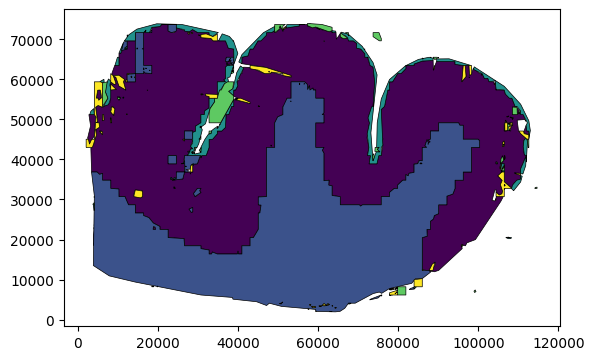

In [43]:
# Remove polygons or holes based on area.
areas = gdf_exploded.area.tolist()

min_area = 10000
tolerance = 300
big_polygon_threshold = 1000

filtered_gdf = gdf_exploded[gdf_exploded.area > min_area].reset_index(drop=True)


# Define a function to remove small holes
def remove_small_holes(polygon, min_hole_area=500):
    """
    Remove small holes (interiors) from a polygon.
    :param polygon: Shapely Polygon object
    :param min_hole_area: Minimum hole area to keep
    :return: Polygon without small holes
    """
    if polygon.interiors:  # Check if there are holes
        new_interiors = [
            hole for hole in polygon.interiors if Polygon(hole).area >= min_hole_area
        ]
        return Polygon(polygon.exterior, new_interiors)
    return polygon


filtered_gdf["geometry"] = filtered_gdf["geometry"].apply(
    lambda geom: remove_small_holes(geom, min_hole_area=min_area)
)

print("After removing by area:", get_point_counts(filtered_gdf))

# If the area is big, add a big simplifier.
for i, row in filtered_gdf.iterrows():
    if row["geometry"].area > big_polygon_threshold:
        filtered_gdf.loc[i, "geometry"] = row["geometry"].simplify(tolerance)
        
print("After smoothing:", get_point_counts(filtered_gdf))

filtered_gdf.plot(column="label", edgecolor="black", linewidth=0.5)

In [44]:
# Conver to DSA elements.
elements = []

for _, row in filtered_gdf.iterrows():    
    poly  = row['geometry']
        
    label = int(row['label'])

    exterior_poly = list(poly.exterior.coords)
    interior_polys = [list(interior.coords) for interior in poly.interiors]

    points = [
        [int(xy[0]), int(xy[1]), 0] for xy in exterior_poly
    ]

    holes = []

    for interior_poly in interior_polys:
        hole = [
            [int(xy[0]), int(xy[1]), 0] for xy in interior_poly
        ]
        holes.append(hole)

    element = {
            "points": points,
            "fillColor": config[label]["fillColor"],
            "lineColor": config[label]['lineColor'],
            "type": "polyline",
            "lineWidth": 2,
            "closed": True,
            "label": {"value": config[label]['label']},
            "group": "Gray White Segmentation"
    }

    if len(holes):
        element["holes"] = holes

    elements.append(element)

In [45]:
_ = gc.post(
    '/annotation',
    parameters={'itemId': item_id},
    json={
        'name': f"17img-20x_minSize{min_area}_tolerance{tolerance}_maxSize{big_polygon_threshold}",
        'description': '',
        'elements': elements,
        "attributes": {}  # this is where you add additional metadata!
    }
)